In [1]:
import cv2
import numpy as np
from matplotlib import pyplot as plt

# Question 3

---



In [2]:
def find_root(conn, x):
    tmp = x
    while conn[tmp] != 0:
        tmp = conn[tmp]
        
    return tmp

def connected_components(im, neigh):
    im = np.int32(im)
    m, n = im.shape
    
    ret = np.zeros((m, n), dtype=int)
    p = 1
    conn = np.zeros((m*n), dtype=int)
    
    # Pass 1
    for i in range(m):
        for j in range(n):
            if im[i][j] == 1:
                arr = np.zeros(4, dtype=int)
                
                if j-1 >= 0:
                    arr[0] = ret[i][j-1]
                    
                if i-1 >= 0:
                    arr[1] = ret[i-1][j]
                    
                if neigh == 8:
                    if i-1 >= 0 and j-1 >= 0:
                        arr[2] = ret[i-1][j-1]
                        
                    if i-1 >= 0 and j+1 < n:
                        arr[3] = ret[i-1][j+1]
                
                arr = arr[arr != 0]
                
                if arr.shape[0] == 0:
                    ret[i][j] = p
                    p += 1
                else:
                    ret[i][j] = np.min(arr)
                    min_root = find_root(conn, ret[i][j])
                    
                    rep = arr[arr != ret[i][j]]
                    rep = np.unique(rep)
                    
                    if rep.shape[0] == 0:
                        continue
                        
                    for k in rep:
                        k_root = find_root(conn, k)
                        
                        if k_root != min_root:
                            conn[k_root] = ret[i][j]
                        
    # Pass 2
    for i in range(m):
        for j in range(n):
            if im[i][j] == 1:
                ret[i][j] = find_root(conn, ret[i][j])
                
    labels = np.unique(ret)
    for i in range(len(labels)):
        ret[ret == labels[i]] = i
    
    return labels.shape[0], ret

In [3]:
def erosion(im, se):
    im = np.int32(im)
    m, n = im.shape
    k, l = se.shape
    
    im = np.vstack((np.zeros(((k-1)//2, n+l-1)), np.hstack((np.zeros((m, (l-1)//2)), im, np.zeros((m, (l-1)//2)))), np.zeros(((k-1)//2, n+l-1))))
    ret = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            ret[i][j] = np.min(im[i:i+k, j:j+l][se == 1])
            
    return ret

def dilation(im, se):
    im = np.int32(im)
    m, n = im.shape
    k, l = se.shape
    
    im = np.vstack((np.zeros(((k-1)//2, n+l-1)), np.hstack((np.zeros((m, (l-1)//2)), im, np.zeros((m, (l-1)//2)))), np.zeros(((k-1)//2, n+l-1))))
    ret = np.zeros((m, n))
    
    for i in range(m):
        for j in range(n):
            ret[i][j] = np.max(im[i:i+k, j:j+l][se == 1])
            
    return ret

def circle_kernel(x):
    k, l = np.meshgrid(np.arange(x), np.arange(x))
    k = k - np.mean(k, axis=1)
    l = l - np.mean(l, axis=0)
    
    ret = np.sqrt(k**2 + l**2)
    
    return np.where(ret <= x//2, 1, 0)

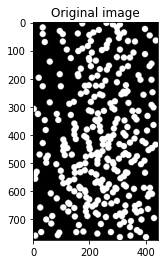

In [6]:
im = cv2.imread('../images/coins.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

_, thresh = cv2.threshold(im, 200, 1, cv2.THRESH_BINARY)

plt.imshow(thresh, cmap='gray')
plt.title("Original image")
plt.show()

#### 1. Only the coins touching the boundary of the image

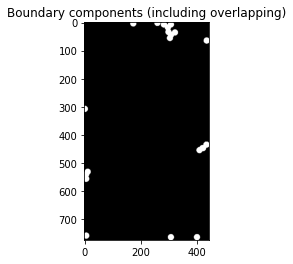

In [49]:
num, labels_im = connected_components(thresh, 4)

m, n = thresh.shape
boundary_coins = np.zeros((m, n), dtype=int)
big_area = np.zeros(num, dtype=int)
small_area = np.zeros(num, dtype=int)

for i in range(m):
    if labels_im[i][0] != 0:
        boundary_coins[labels_im == labels_im[i][0]] = 1
        if np.sum(labels_im == labels_im[i][0]) > 500:
            big_area[labels_im[i][0]] = 1
        else:
            small_area[labels_im[i][0]] = 1
    
    if labels_im[i][n-1] != 0:
        boundary_coins[labels_im == labels_im[i][n-1]] = 1
        if np.sum(labels_im == labels_im[i][n-1]) > 500:
            big_area[labels_im[i][n-1]] = 1
        else:
            small_area[labels_im[i][n-1]] = 1
for i in range(n):
    if labels_im[0][i] != 0:
        boundary_coins[labels_im == labels_im[0][i]] = 1
        if np.sum(labels_im == labels_im[0][i]) > 500:
            big_area[labels_im[0][i]] = 1
        else:
            small_area[labels_im[0][i]] = 1
            
    if labels_im[m-1][i] != 0:
        boundary_coins[labels_im == labels_im[m-1][i]] = 1
        if np.sum(labels_im == labels_im[m-1][i]) > 500:
            big_area[labels_im[m-1][i]] = 1
        else:
            small_area[labels_im[m-1][i]] = 1
            
plt.imshow(boundary_coins, cmap='gray')
plt.title("Boundary components (including overlapping)")
plt.show()

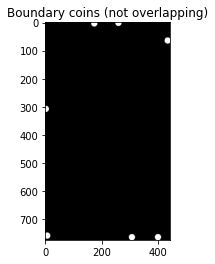

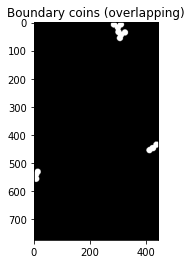

In [50]:
good_c = np.zeros((m, n), dtype=int)
bad_c = np.zeros((m, n), dtype=int)

for i in range(1, num):
    if small_area[i] == 1:
        good_c[labels_im == i] = 1
        
    if big_area[i] == 1:
        bad_c[labels_im == i] = 1

plt.imshow(good_c, cmap='gray')
plt.title("Boundary coins (not overlapping)")
plt.show()

plt.imshow(bad_c, cmap='gray')
plt.title("Boundary coins (overlapping)")
plt.show()

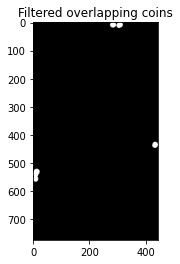

In [51]:
kernel = circle_kernel(9)
kernel1 = circle_kernel(11)

erode = erosion(bad_c, kernel)
erode1 = erosion(erode, kernel1)

num, labels_im = connected_components(erode1, 4)
bad_boundary = np.zeros((m, n), dtype=int)

for i in range(m):
    for j in range(10):
        if labels_im[i][j] != 0:
            bad_boundary[labels_im == labels_im[i][j]] = 1
    
        if labels_im[i][n-j-1] != 0:
            bad_boundary[labels_im == labels_im[i][n-j-1]] = 1

for i in range(n):
    for j in range(10):
        if labels_im[j][i] != 0:
            bad_boundary[labels_im == labels_im[j][i]] = 1
            
        if labels_im[m-j-1][i] != 0:
            bad_boundary[labels_im == labels_im[m-j-1][i]] = 1

dilate = dilation(bad_boundary, kernel1)
dilate1 = dilation(dilate, kernel)

plt.imshow(dilate1, cmap='gray')
plt.title("Filtered overlapping coins")
plt.show()

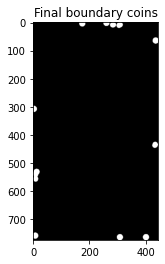

In [52]:
final_boundary = np.zeros((m, n), dtype=int)
final_boundary = good_c + dilate1

plt.imshow(final_boundary, cmap='gray')
plt.title("Final boundary coins")
plt.show()

#### 2. Only the coins which overlap with each other

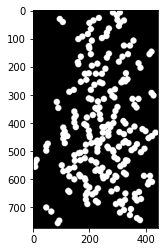

In [66]:
num_lab, labels_im = connected_components(thresh, 4)

ret = np.zeros(num_lab)
for i in range(num_lab):
    if np.sum(labels_im == i) > 500 and np.sum(labels_im == i) < 240000:
        ret[i] = 1
        
new = np.where(ret[labels_im], 1, 0)

plt.imshow(new, cmap='gray')
plt.show()

#### 3. Only non-overlapping coins

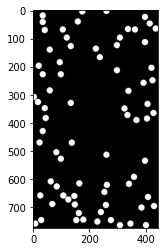

In [67]:
num_lab, labels_im = connected_components(thresh, 4)

ret = np.zeros(num_lab)
for i in range(num_lab):
    if np.sum(labels_im == i) < 500:
        ret[i] = 1
        
new = np.where(ret[labels_im], 1, 0)

plt.imshow(new, cmap='gray')
plt.show()